## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Loading and combining the datasets

In [2]:
try:
    df1 = pd.read_csv('dataset/WIPMoveDetailData.csv')
    df2 = pd.read_csv('dataset/WIPMoveDetailData (1).csv')
    df3 = pd.read_csv('dataset/WIPMoveDetailData (2).csv')

    print("All three files loaded successfully!")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure the CSV files are in the same directory as your Jupyter Notebook.")


combined_df = pd.concat([df1, df2, df3], ignore_index=True)
print("\n--- DataFrames combined successfully! ---")

All three files loaded successfully!

--- DataFrames combined successfully! ---


## Data Exploration

In [3]:
# Display the shape of the combined DataFrame (rows, columns)
print(f"\nShape of the combined data: {combined_df.shape}")


Shape of the combined data: (75340, 32)


In [4]:
# This is crucial for checking data types (e.g., is 'Create time' a string or a datetime?)
# and seeing the number of non-null values per column.
print("\n\n--- DataFrame Info ---")
combined_df.info()



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75340 entries, 0 to 75339
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   No.                          75340 non-null  int64  
 1   Module no                    75340 non-null  object 
 2   Workorder no                 75340 non-null  object 
 3   Material code                75340 non-null  int64  
 4   Room                         75340 non-null  object 
 5   Line Code                    75340 non-null  object 
 6   Shift                        75340 non-null  object 
 7   Equipment Code               75340 non-null  object 
 8   Activity                     64 non-null     float64
 9   Route                        75340 non-null  object 
 10  Responsible Route operation  75340 non-null  object 
 11  Quantity                     75340 non-null  int64  
 12  Grade                        9784 non-null   obje

In [5]:
# This helps you get a feel for the data's content and structure.
print("\n\n--- First 5 Rows of Combined Data ---")
print(combined_df.head())



--- First 5 Rows of Combined Data ---
   No.          Module no Workorder no  Material code     Room Line Code  \
0    1  SL2125TGTG0891443      2000614       22000020  UNIT-01   LINE-01   
1    2  SL2125TGTG0891434      2000614       22000020  UNIT-01   LINE-01   
2    3  SL2125TGTG0891433      2000614       22000020  UNIT-01   LINE-01   
3    4  SL2125TGTG0891375      2000614       22000020  UNIT-01   LINE-01   
4    5  SL2125TGTG0891397      2000614       22000020  UNIT-01   LINE-01   

  Shift   Equipment Code  Activity        Route  ... UNDO_FLAG  Description  \
0     A  Sael01-01-BUF01       1.0  MainProcess  ...       NaN          NaN   
1     A  Sael01-01-BUF01       1.0  MainProcess  ...       NaN          NaN   
2     A  Sael01-01-BUF01       1.0  MainProcess  ...       NaN          NaN   
3     A  Sael01-01-BUF01       1.0  MainProcess  ...       NaN          NaN   
4     A  Sael01-01-BUF01       1.0  MainProcess  ...       NaN          NaN   

  Unnamed: 14  Unnamed: 16 U

In [6]:
# Check for missing values in each column.
# This is a critical step to inform your data cleaning strategy for the next phase.
print("\n\n--- Count of Missing Values per Column ---")
print(combined_df.isnull().sum())



--- Count of Missing Values per Column ---
No.                                0
Module no                          0
Workorder no                       0
Material code                      0
Room                               0
Line Code                          0
Shift                              0
Equipment Code                     0
Activity                       75276
Route                              0
Responsible Route operation        0
Quantity                           0
Grade                          65556
Color                          75340
Trackout_Desc                  75276
Recode                         75340
Reason_desc                    75340
Position                       75340
Create time                        0
Creator                            0
ACTIVITY                          64
TimesFlag                         64
UNDO_FLAG                         64
Description                    65564
Unnamed: 14                    75340
Unnamed: 16                   

 ## Data Preprocessing and Cleaning

In [7]:
df_cleaned = combined_df.copy()

In [8]:
# create a list of columns to drop.
columns_to_drop = [
    # Completely empty columns
    'Color', 'Recode', 'Reason_desc', 'Position',
    # Unnamed artifact columns
    'Unnamed: 14', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
    'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
    # Highly null columns that are not critical for a baseline model
    'Grade', 'Description', 'Trackout_Desc',
    # Redundant index column
    'No.'
]
df_cleaned = df_cleaned.drop(columns=columns_to_drop)
print("--- Dropped unnecessary columns. ---")


--- Dropped unnecessary columns. ---


In [9]:
# ---  Handle Duplicate 'Activity' Columns ---
# There are two columns: 'Activity' and 'ACTIVITY'. Let's merge them.
# We'll fill NaN values in 'ACTIVITY' with values from 'Activity', then drop the original 'Activity'.
df_cleaned['ACTIVITY'] = df_cleaned['ACTIVITY'].fillna(df_cleaned['Activity'])
df_cleaned = df_cleaned.drop(columns=['Activity'])
print("--- Merged duplicate 'Activity' columns. ---")

--- Merged duplicate 'Activity' columns. ---


In [10]:
# --- Correct Data Types ---
# Convert 'Create time' from object (string) to datetime format. This is CRITICAL.
# The `errors='coerce'` flag will turn any un-parseable dates into NaT (Not a Time), which can be handled later.
df_cleaned['Create time'] = pd.to_datetime(df_cleaned['Create time'], errors='coerce')

In [11]:
# Let's inspect the 'UNDO_FLAG' before converting it.
print(f"\nUnique values in 'UNDO_FLAG' before conversion: {df_cleaned['UNDO_FLAG'].unique()}")



Unique values in 'UNDO_FLAG' before conversion: [nan False]


In [12]:

# We'll treat NaN values as False (assuming no undo means the action was final).
df_cleaned['UNDO_FLAG'] = df_cleaned['UNDO_FLAG'].replace({'True': True, 'False': False}).fillna(False).astype(bool)
print("--- Converted 'Create time' to datetime and 'UNDO_FLAG' to boolean. ---")

--- Converted 'Create time' to datetime and 'UNDO_FLAG' to boolean. ---


C:\Users\anand\AppData\Local\Temp\ipykernel_7024\3966112463.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned['UNDO_FLAG'] = df_cleaned['UNDO_FLAG'].replace({'True': True, 'False': False}).fillna(False).astype(bool)


In [13]:
# --- 5. Sort Data Chronologically ---
# All time-series analysis requires the data to be in the correct order.
df_cleaned = df_cleaned.sort_values(by='Create time').reset_index(drop=True)
print("--- Sorted DataFrame by 'Create time'. ---")


--- Sorted DataFrame by 'Create time'. ---


In [14]:
# --- 6. Final Inspection of Cleaned Data ---
print("\n\n--- Cleaned DataFrame Info ---")
df_cleaned.info()




--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75340 entries, 0 to 75339
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Module no                    75340 non-null  object        
 1   Workorder no                 75340 non-null  object        
 2   Material code                75340 non-null  int64         
 3   Room                         75340 non-null  object        
 4   Line Code                    75340 non-null  object        
 5   Shift                        75340 non-null  object        
 6   Equipment Code               75340 non-null  object        
 7   Route                        75340 non-null  object        
 8   Responsible Route operation  75340 non-null  object        
 9   Quantity                     75340 non-null  int64         
 10  Create time                  75340 non-null  datetime64[ns]
 11  Creator 

In [15]:
print("\n\n--- First 5 Rows of Cleaned DataFrame ---")
print(df_cleaned.head())



--- First 5 Rows of Cleaned DataFrame ---
           Module no Workorder no  Material code     Room Line Code Shift  \
0  SL2225TGTG0591113      2000504       22000020  UNIT-01   LINE-02     A   
1  SL2325TGTG0591874      2000505       22000020  UNIT-01   LINE-03     A   
2  SL2325TGTG0591804      2000505       22000020  UNIT-01   LINE-03     A   
3  SL2325TGTG0591844      2000505       22000020  UNIT-01   LINE-03     A   
4  SL2325TGTG0591871      2000505       22000020  UNIT-01   LINE-03     A   

    Equipment Code        Route Responsible Route operation  Quantity  \
0  Sael01-02-IVT01  MainProcess                Flasher Test         1   
1  Sael01-03-IVT01  MainProcess                Flasher Test         1   
2  Sael01-03-IVT01     IVretest                FLASHER TEST         1   
3  Sael01-03-IVT01  MainProcess                Flasher Test         1   
4  Sael01-03-IVT01  MainProcess                Flasher Test         1   

          Create time Creator  ACTIVITY  TimesFlag  UN

In [16]:

print("\n\n--- Missing Values Count in Cleaned DataFrame ---")
print(df_cleaned.isnull().sum())



--- Missing Values Count in Cleaned DataFrame ---
Module no                       0
Workorder no                    0
Material code                   0
Room                            0
Line Code                       0
Shift                           0
Equipment Code                  0
Route                           0
Responsible Route operation     0
Quantity                        0
Create time                     0
Creator                         0
ACTIVITY                        0
TimesFlag                      64
UNDO_FLAG                       0
dtype: int64


## Feature Engineering and Target Definition

In [17]:
# This code assumes 'df_cleaned' is available and ready.
df_cleaned_sorted = df_cleaned.sort_values(by=['Equipment Code', 'Create time']).reset_index(drop=True)
df_final_features = df_cleaned_sorted.copy()

In [18]:
# --- 1. Define the Target Variable ---
df_final_features['is_failure'] = np.where(df_final_features['Creator'] == 'ADMIN', 1, 0)
print("--- Step 1: Target variable 'is_failure' created. ---")


--- Step 1: Target variable 'is_failure' created. ---


In [19]:
# --- 2. Create All Predictive Features ---

# Feature Group A: Basic Time-Series Features
print("--- Step 2a: Creating basic time-series features... ---")
df_final_features['time_delta_s'] = df_final_features.groupby('Equipment Code')['Create time'].diff().dt.total_seconds()
df_final_features['time_delta_rolling_avg'] = df_final_features.groupby('Equipment Code')['time_delta_s'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
df_final_features['time_delta_rolling_std'] = df_final_features.groupby('Equipment Code')['time_delta_s'].transform(lambda x: x.rolling(window=10, min_periods=1).std())

# Feature Group B: Advanced Lag Features
print("--- Step 2b: Creating advanced lag features... ---")
df_final_features['time_delta_s_lag_1'] = df_final_features.groupby('Equipment Code')['time_delta_s'].shift(1)
df_final_features['time_delta_s_lag_2'] = df_final_features.groupby('Equipment Code')['time_delta_s'].shift(2)

# Feature Group C: Advanced Workload/Instability Features (DEFINITIVE FIX 3)
print("--- Step 2c: Creating advanced workload features... ---")
df_final_features['is_operator_action'] = np.where(df_final_features['Creator'] == 'OPERATOR', 1, 0)

# 1. Calculate the rolling sum. The result will have a scrambled MultiIndex.
rolling_op_counts_series = df_final_features.groupby('Equipment Code').rolling(
    '1h', on='Create time', closed='left'
)['is_operator_action'].sum()

# 2. The result's index is ('Equipment Code', original_index).
#    Drop the 'Equipment Code' level to get a Series indexed by the original index.
rolling_op_counts_series = rolling_op_counts_series.reset_index(level=0, drop=True)

# 3. CRITICAL STEP: Sort the result by its index. This puts the values back
#    into the original order of the DataFrame.
rolling_op_counts_series = rolling_op_counts_series.sort_index()

# 4. Assign the raw .values. This bypasses any index alignment checks and works
#    because we have guaranteed the order is correct.
df_final_features['operator_action_rolling_count_1h'] = rolling_op_counts_series.values

print("Successfully created 'operator_action_rolling_count_1h' feature.")

--- Step 2a: Creating basic time-series features... ---
--- Step 2b: Creating advanced lag features... ---
--- Step 2c: Creating advanced workload features... ---
Successfully created 'operator_action_rolling_count_1h' feature.


In [20]:
# --- 3. Final Preparation for Modeling ---
print("--- Step 3: Final data preparation... ---")
df_final_features = pd.get_dummies(df_final_features, columns=['Shift', 'Route'], prefix=['shift', 'route'])
df_final_features.fillna(0, inplace=True)
df_final_features = df_final_features.drop(columns=['is_operator_action'])

print("\n--- Feature Engineering Complete! ---")

--- Step 3: Final data preparation... ---

--- Feature Engineering Complete! ---


In [21]:
# --- 4. Final Inspection ---
print("\n--- Final DataFrame Info: ---")
df_final_features.info()


--- Final DataFrame Info: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75340 entries, 0 to 75339
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Module no                         75340 non-null  object        
 1   Workorder no                      75340 non-null  object        
 2   Material code                     75340 non-null  int64         
 3   Room                              75340 non-null  object        
 4   Line Code                         75340 non-null  object        
 5   Equipment Code                    75340 non-null  object        
 6   Responsible Route operation       75340 non-null  object        
 7   Quantity                          75340 non-null  int64         
 8   Create time                       75340 non-null  datetime64[ns]
 9   Creator                           75340 non-null  object        
 10  ACTIVITY       

In [22]:
print("\n--- First 5 Rows of Final DataFrame: ---")
display_cols = ['Module no', 'Equipment Code', 'Create time', 'is_failure', 'time_delta_s', 'time_delta_rolling_std', 'time_delta_s_lag_1', 'operator_action_rolling_count_1h'] + [col for col in df_final_features.columns if 'route_' in col]
print(df_final_features[display_cols].head())


--- First 5 Rows of Final DataFrame: ---
           Module no   Equipment Code         Create time  is_failure  \
0  SL2125TGTG0891443  Sael01-01-BUF01 2025-03-31 08:00:05           0   
1  SL2125TGTG0891434  Sael01-01-BUF01 2025-03-31 08:00:21           0   
2  SL2125TGTG0891433  Sael01-01-BUF01 2025-03-31 08:01:10           0   
3  SL2125TGTG0891375  Sael01-01-BUF01 2025-03-31 08:01:58           0   
4  SL2125TGTG0891397  Sael01-01-BUF01 2025-03-31 08:02:14           0   

   time_delta_s  time_delta_rolling_std  time_delta_s_lag_1  \
0           0.0                0.000000                 0.0   
1          16.0                0.000000                 0.0   
2          49.0               23.334524                16.0   
3          48.0               18.770544                49.0   
4          16.0               18.768324                48.0   

   operator_action_rolling_count_1h  route_IVretest  route_MainProcess  \
0                               0.0           False               

In [23]:
#Saving th sample of final datasets fot testng the model after deployment 

# Select the columns you want to include in the sample file
sample_cols = [
    'Module no',
    'Equipment Code',
    'Create time',
    'is_failure',
    'time_delta_s',
    'time_delta_rolling_avg',
    'time_delta_rolling_std',
    'time_delta_s_lag_1',
    'time_delta_s_lag_2',
    'operator_action_rolling_count_1h',
    'ACTIVITY',
    'TimesFlag',
    'shift_A',
    'shift_B',
    'route_IVretest',
    'route_MainProcess',
    'route_PostReworkProcess',
    'route_ReworkProcess'
]

# Take a sample of 30 rows from your final dataset
sample_df = df_final_features[sample_cols].sample(30, random_state=42)

# Save the sample CSV
sample_df.to_csv("sample_preprocessed_input.csv", index=False)

print("Saved: sample_preprocessed_input.csv")
sample_df.head()


Saved: sample_preprocessed_input.csv


,Module no,Equipment Code,Create time,is_failure,time_delta_s,time_delta_rolling_avg,time_delta_rolling_std,time_delta_s_lag_1,time_delta_s_lag_2,operator_action_rolling_count_1h,ACTIVITY,TimesFlag,shift_A,shift_B,route_IVretest,route_MainProcess,route_PostReworkProcess,route_ReworkProcess
3259,SL2125TGTG0780172,Sael01-01-IVT01,2025-03-19 14:59:51,0,41.0,30.1,9.848293,32.0,21.0,74.0,1.0,7.0,True,False,False,True,False,False
34339,SL2225TGTG0621634,Sael01-02-IVT01,2025-03-04 12:44:09,0,25.0,44.1,30.780405,30.0,47.0,71.0,1.0,7.0,True,False,True,False,False,False
51203,SL2225TGTG0871991,Sael01-02-IVT01,2025-03-29 10:41:18,0,64.0,45.4,29.394633,14.0,48.0,106.0,1.0,7.0,True,False,False,True,False,False
59512,SL2225TGTG2292787,Sael01-02-LAY01,2025-08-20 02:59:10,0,14.0,18.3,16.646988,26.0,36.0,29.0,1.0,7.0,False,True,False,True,False,False
9666,SL2125TGTG0790589,Sael01-01-IVT01,2025-03-22 08:39:12,0,20.0,30.7,13.474667,25.0,15.0,0.0,1.0,7.0,True,False,False,True,False,False


In [53]:
# Number of rows for each sample file
SAMPLE_SIZE = 15

# Sample 2 different random subsets
sample2 = df_final_features.sample(n=SAMPLE_SIZE, random_state=40)
sample3 = df_final_features.sample(n=SAMPLE_SIZE, random_state=99)

# Save them as CSV files
sample2.to_csv("sample_preprocessed_input_2.csv", index=False)
sample3.to_csv("sample_preprocessed_input_3.csv", index=False)

print("Saved sample_preprocessed_input_2.csv and sample_preprocessed_input_3.csv")

Saved sample_preprocessed_input_2.csv and sample_preprocessed_input_3.csv


## Model Building and Evaluation

In [24]:
# This is the DataFrame we just created in the previous step
df_model_ready = df_final_features.copy()

In [25]:
# --- 1. Feature Selection ---
# Select the columns we will use to train the model.
features = [
    'ACTIVITY',
    'TimesFlag',
    'time_delta_s',
    'time_delta_rolling_avg',
    'time_delta_rolling_std',
    'time_delta_s_lag_1',
    'time_delta_s_lag_2',
    'operator_action_rolling_count_1h',
    'shift_A',
    'shift_B',
    'route_IVretest',
    'route_MainProcess',
    'route_PostReworkProcess',
    'route_ReworkProcess'
]

X = df_final_features[features]
y = df_final_features['is_failure']

print("--- Final features (X) and target (y) are defined. ---")


--- Final features (X) and target (y) are defined. ---


In [26]:
# --- 2. Stratified Data Split ---
# This ensures both train and test sets have a representative number of failures.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("\n--- Data split into training and testing sets. ---")


--- Data split into training and testing sets. ---


### Model 1 :- Logistic Regression 

In [27]:
print("\n\n--- Training Model 1: Logistic Regression (Baseline) ---")
# We use class_weight='balanced' to help the model handle the imbalanced dataset
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)



--- Training Model 1: Logistic Regression (Baseline) ---


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [28]:
# Make predictions
y_pred_lr = lr_model.predict(X_test)


--- Evaluation: Logistic Regression ---
Confusion Matrix:


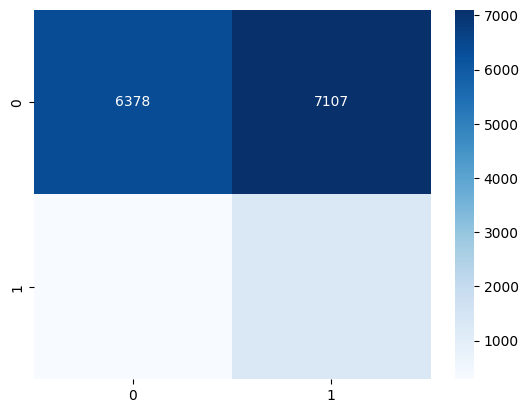

In [29]:
print("\n--- Evaluation: Logistic Regression ---")
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='g', cmap='Blues')
plt.show()

In [30]:
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=['Normal (0)', 'Failure (1)']))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  Normal (0)       0.96      0.47      0.63     13485
 Failure (1)       0.15      0.82      0.26      1583

    accuracy                           0.51     15068
   macro avg       0.56      0.65      0.45     15068
weighted avg       0.87      0.51      0.59     15068



### Model 2 :- Random Forest

In [31]:
print("\n\n--- Training Model 2: Random Forest Classifier ---")
# We also use class_weight='balanced' here
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)



--- Training Model 2: Random Forest Classifier ---


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)


--- Evaluation: Random Forest ---
Confusion Matrix:


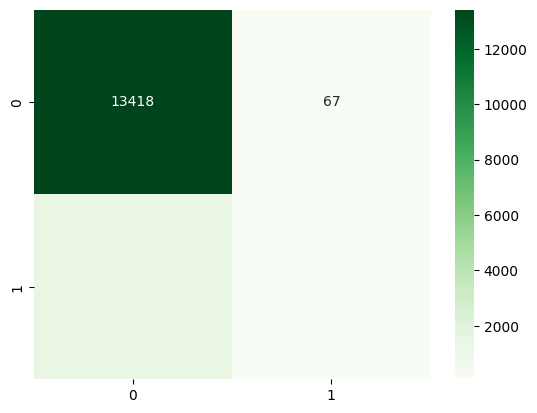

In [33]:
print("\n--- Evaluation: Random Forest ---")
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='g', cmap='Greens')
plt.show()

In [34]:
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Normal (0)', 'Failure (1)']))


Classification Report (Random Forest):
              precision    recall  f1-score   support

  Normal (0)       0.90      1.00      0.95     13485
 Failure (1)       0.60      0.06      0.11      1583

    accuracy                           0.90     15068
   macro avg       0.75      0.53      0.53     15068
weighted avg       0.87      0.90      0.86     15068




--- Feature Importances (Random Forest) ---
operator_action_rolling_count_1h    0.277602
time_delta_rolling_std              0.165866
time_delta_rolling_avg              0.153440
time_delta_s                        0.128040
time_delta_s_lag_1                  0.124165
time_delta_s_lag_2                  0.122985
shift_A                             0.007513
shift_B                             0.006852
route_IVretest                      0.006747
route_MainProcess                   0.006318
TimesFlag                           0.000286
route_ReworkProcess                 0.000176
route_PostReworkProcess             0.000009
ACTIVITY                            0.000000
dtype: float64


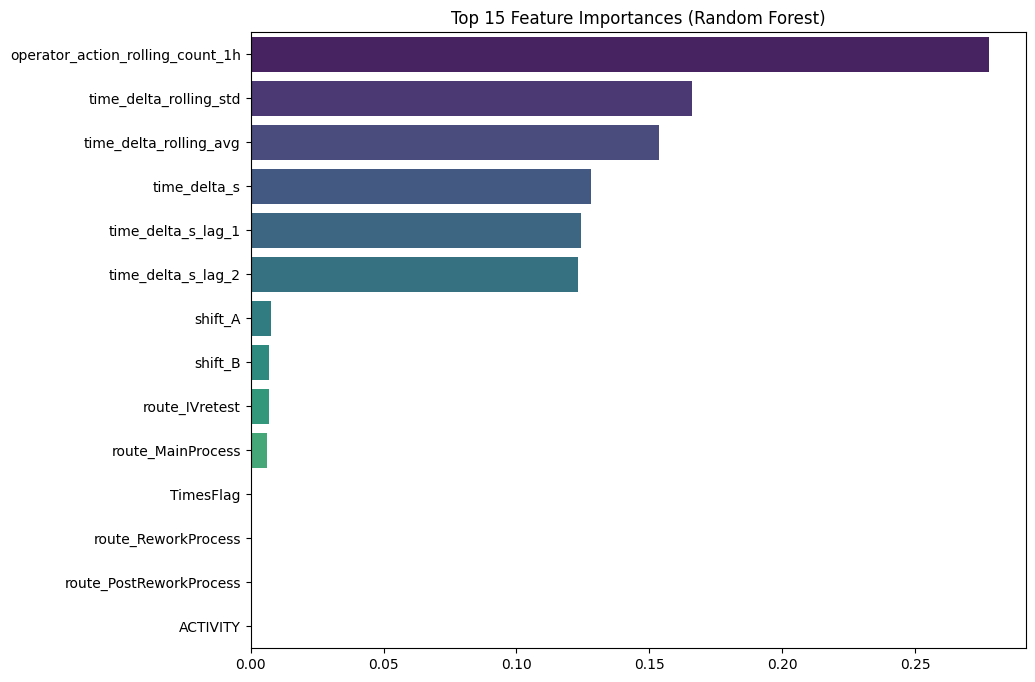

In [35]:
print("\n--- Feature Importances (Random Forest) ---")
importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances_rf.head(15))
plt.figure(figsize=(10, 8))
sns.barplot(x=importances_rf.head(15), y=importances_rf.head(15).index, palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

### Model 3 :- XGBoost Model Training

In [36]:
print("\n\n--- Training Final XGBoost Model ---")

# Calculate scale_pos_weight for handling class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight for imbalance: {scale_pos_weight:.2f}")



--- Training Final XGBoost Model ---
Calculated scale_pos_weight for imbalance: 8.52


In [37]:
# Initialize and train the XGBClassifier with strong starting parameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

C:\Users\anand\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Final Evaluation: XGBoost Model ---
Confusion Matrix:


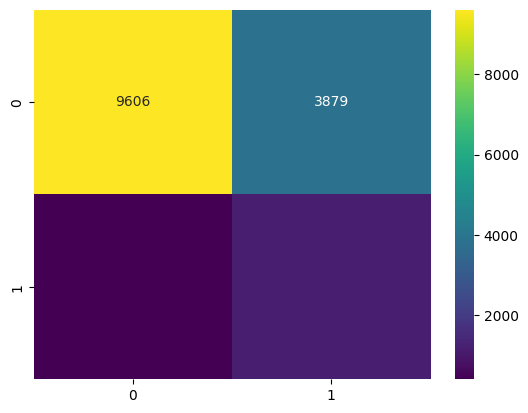

In [38]:
# --- 4. Final Evaluation ---
print("\n--- Final Evaluation: XGBoost Model ---")

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='g', cmap='viridis')
plt.show()



Classification Report (XGBoost Model):
              precision    recall  f1-score   support

  Normal (0)       0.96      0.71      0.82     13485
 Failure (1)       0.23      0.74      0.35      1583

    accuracy                           0.72     15068
   macro avg       0.60      0.73      0.59     15068
weighted avg       0.88      0.72      0.77     15068



--- Feature Importances from the XGBoost Model ---
operator_action_rolling_count_1h    0.221617
route_IVretest                      0.132396
route_MainProcess                   0.121994
shift_B                             0.117859
shift_A                             0.105143
time_delta_rolling_std              0.054260
time_delta_rolling_avg              0.054048
time_delta_s                        0.052980
time_delta_s_lag_1                  0.048669
time_delta_s_lag_2                  0.048043
TimesFlag                           0.022113
route_ReworkProcess                 0.020876
ACTIVITY                            0.00

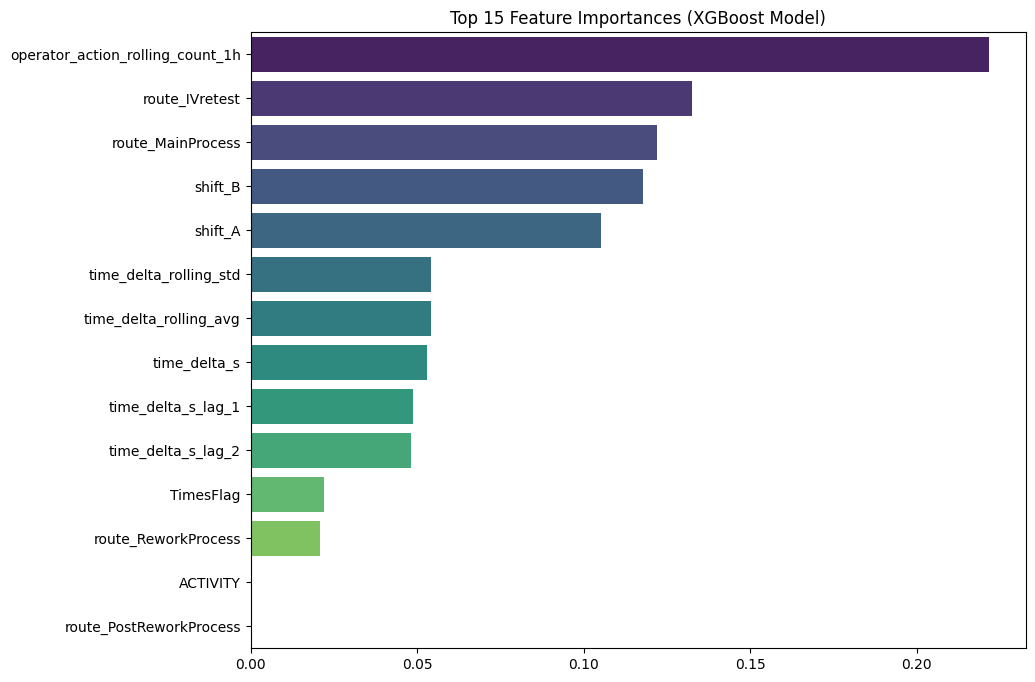

In [39]:
print("\nClassification Report (XGBoost Model):")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal (0)', 'Failure (1)']))

print("\n\n--- Feature Importances from the XGBoost Model ---")
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(15)) # Print top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
plt.title('Top 15 Feature Importances (XGBoost Model)')
plt.show()

### 1. Hyperparameter Tuning using GridSearchCV

In [40]:
print("\n\n--- Starting Hyperparameter Tuning for XGBoost ---")
print("This can take several minutes to run...")



--- Starting Hyperparameter Tuning for XGBoost ---
This can take several minutes to run...


In [41]:
# Calculate scale_pos_weight for handling class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight for imbalance: {scale_pos_weight:.2f}")

Calculated scale_pos_weight for imbalance: 8.52


In [42]:
# Define the base model we want to tune
xgb_for_tuning = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)

In [43]:
# Define a grid of parameters to search through
# This is a focused grid. You can expand it, but it will take longer to run.
param_grid = {
    'max_depth': [3, 5, 7],         # Depth of the trees
    'n_estimators': [100, 200],     # Number of trees
    'learning_rate': [0.01, 0.1]    # How fast the model learns
}

1. Set up the grid search. We'll use 'f1_weighted' as our scoring metric as it's a good choice for imbalanced datasets.
2. cv=3 means 3-fold cross-validation.
3. verbose=2 will print updates so you know it's working.

In [44]:
grid_search = GridSearchCV(
    estimator=xgb_for_tuning,
    param_grid=param_grid,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=3,
    verbose=2
)

In [45]:
# Fit the grid search to the training data to find the best parameters
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\anand\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,estimator,"XGBClassifier...state=42, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [46]:
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)


Best parameters found by GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [47]:
# Get the best model that the grid search found
best_tuned_model = grid_search.best_estimator_


--- Final Evaluation: Tuned XGBoost Model ---
Confusion Matrix (Tuned Model):


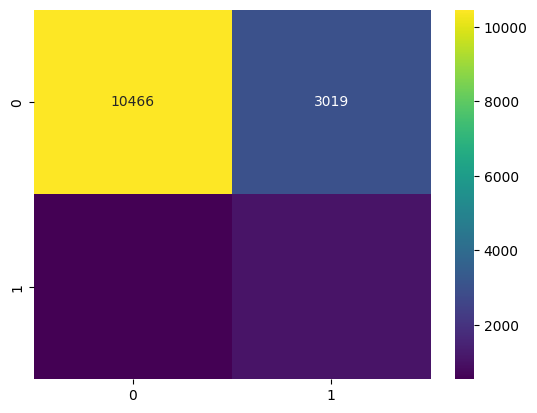

In [48]:
# --- 2. Final Evaluation of the BEST Tuned Model ---
print("\n--- Final Evaluation: Tuned XGBoost Model ---")
y_pred_final = best_tuned_model.predict(X_test)

print("Confusion Matrix (Tuned Model):")
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='g', cmap='viridis')
plt.show()

In [49]:
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_final, target_names=['Normal (0)', 'Failure (1)']))


Classification Report (Tuned Model):
              precision    recall  f1-score   support

  Normal (0)       0.95      0.78      0.85     13485
 Failure (1)       0.26      0.66      0.37      1583

    accuracy                           0.76     15068
   macro avg       0.60      0.72      0.61     15068
weighted avg       0.88      0.76      0.80     15068





--- Feature Importances from the Tuned XGBoost Model ---
operator_action_rolling_count_1h    0.166767
route_MainProcess                   0.141148
shift_B                             0.117218
route_IVretest                      0.117106
shift_A                             0.104111
time_delta_rolling_std              0.060615
time_delta_rolling_avg              0.055467
route_ReworkProcess                 0.052502
time_delta_s                        0.051332
time_delta_s_lag_1                  0.050549
time_delta_s_lag_2                  0.049502
TimesFlag                           0.033684
ACTIVITY                            0.000000
route_PostReworkProcess             0.000000
dtype: float32


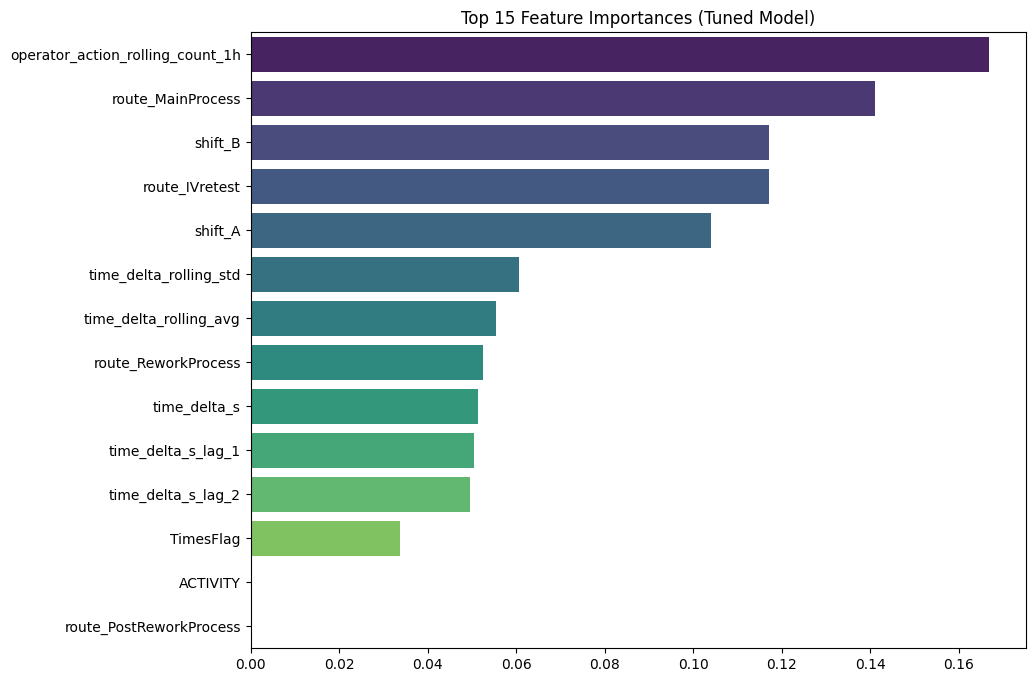

In [50]:
print("\n\n--- Feature Importances from the Tuned XGBoost Model ---")
importances = pd.Series(best_tuned_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(15)) # Print top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
plt.title('Top 15 Feature Importances (Tuned Model)')
plt.show()

In [55]:
# --- 3. Save Your Final, Tuned Model ---
import joblib
model = joblib.load("tuned_predictive_maintenance_model.joblib")
